In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torchmetrics
from collections import Counter

In [2]:
# 檢查是否可用 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == 'cuda':
    print(torch.cuda.get_device_name(device))
    print(torch.cuda.get_device_properties(device))

    # 清除 CUDA 設備的未使用內存
    torch.cuda.empty_cache()
else:
    print("CUDA is not available. Using CPU.")

NVIDIA GeForce RTX 4070 SUPER
_CudaDeviceProperties(name='NVIDIA GeForce RTX 4070 SUPER', major=8, minor=9, total_memory=12281MB, multi_processor_count=56)


### 下載資料集

In [3]:
# 數據增強
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=30),  # 先旋轉再裁切
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),  # 隨機地將圖像水平翻轉，翻轉概率為 50%
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # 隨機改變圖像的亮度、對比度、飽和度和色調
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 下載資料
train_dataset = datasets.Flowers102(root='./data', split='test', download=True, transform=train_transform)  # 把 train / test 反過來
val_dataset = datasets.Flowers102(root='./data', split='val', download=True, transform=test_transform)
test_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=test_transform)

In [4]:
NUM_CLASSES = 102

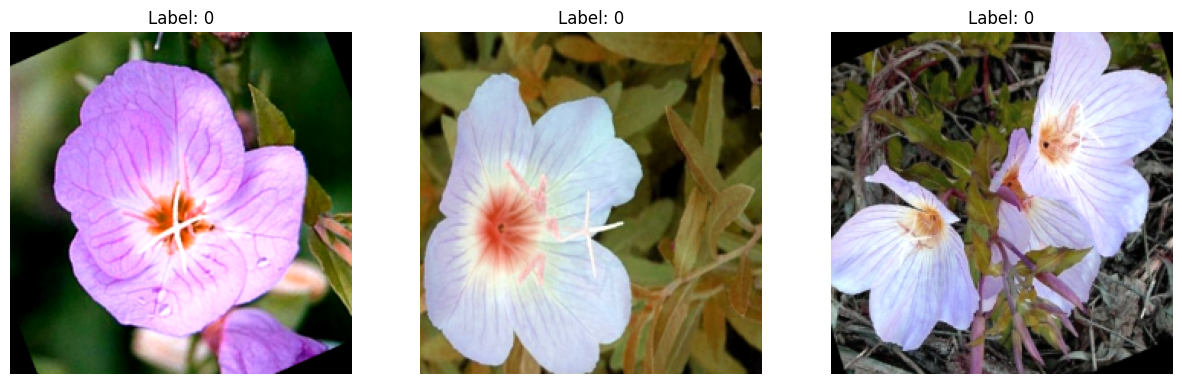

Number of Classes: 102
Number of samples in training set: 6149
Number of samples in validation set: 1020
Number of samples in test set: 1020


In [5]:
# 預覽幾張圖片
inv_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):  
    image, label = train_dataset[i]
    img = inv_normalize(image)
    npimg = img.numpy()

    axes[i].imshow(np.transpose(npimg, (1, 2, 0)))
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')
plt.show()

# 統計每個類別的樣本數
train_labels = train_dataset._labels
label_counts = Counter(train_labels)

# 顯示類別的總數
print(f"Number of Classes: {len(label_counts)}")

# 顯示不同資料集的大小
print(f"Number of samples in training set: {len(train_dataset)}")
print(f"Number of samples in validation set: {len(val_dataset)}")
print(f"Number of samples in test set: {len(test_dataset)}")

### ResNet Model

In [7]:
# Residual Block
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout_prob=0, activation_fn=nn.ReLU):
        super(BasicBlock, self).__init__()

        self.activation_fn = activation_fn(inplace=True)

        # Dropout 用於防止過擬合
        self.dropout = nn.Dropout(p=dropout_prob)

        # 第一個卷積層
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # 第二個卷積層
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # 當輸入的尺寸和輸出尺寸不匹配時，使用 1x1 的卷積核和 BatchNorm 對輸入進行下採樣來調整尺寸
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        shortcut = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation_fn(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += shortcut
        out = self.activation_fn(out)
        out = self.dropout(out)
        return out


class ResNet34(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, activation_fn=nn.ReLU):
        super(ResNet34, self).__init__()

        self.activation_fn = activation_fn(inplace=True)

        # 第一個卷積層
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # 初始輸入通道數，經過第一層後通道數為64
        self.in_channels = 64

        # 四個殘差層，使用 BasicBlock 作為基礎構建單元
        self.layer1 = self._make_layer(BasicBlock, out_channels=64, num_blocks=3, stride=1, dropout_prob=0.0, activation_fn=activation_fn)
        self.layer2 = self._make_layer(BasicBlock, out_channels=128, num_blocks=4, stride=2, dropout_prob=0.0, activation_fn=activation_fn)
        self.layer3 = self._make_layer(BasicBlock, out_channels=256, num_blocks=6, stride=2, dropout_prob=0.0, activation_fn=activation_fn)
        self.layer4 = self._make_layer(BasicBlock, out_channels=512, num_blocks=3, stride=2, dropout_prob=0.3, activation_fn=activation_fn)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        # Dropout 防止過擬合
        self.dropout = nn.Dropout(p=0.5)

    def _make_layer(self, block, out_channels, num_blocks, stride, dropout_prob, activation_fn):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, dropout_prob, activation_fn))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels, 1, dropout_prob, activation_fn))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # origin image : (3, 224, 224)
        x = self.conv1(x)  # image : (64, 112, 112)
        x = self.bn1(x)
        x = self.activation_fn(x)
        x = self.maxpool(x)  # image : (64, 56, 56)
        x = self.layer1(x)  # image : (64, 56, 56)
        x = self.layer2(x)  # image : (128, 28, 28)
        x = self.layer3(x)  # image : (256, 14, 14)
        x = self.layer4(x)  # image : (512, 7, 7)
        x = self.avgpool(x)  # image : (512, 1, 1)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


class ResNet18(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, activation_fn=nn.ReLU):
        super(ResNet18, self).__init__()

        self.activation_fn = activation_fn(inplace=True)

        # 第一個卷積層
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # 初始輸入通道數，經過第一層後通道數為64
        self.in_channels = 64

        # 四個殘差層，使用 BasicBlock 作為基礎構建單元
        self.layer1 = self._make_layer(BasicBlock, out_channels=64, num_blocks=2, stride=1, dropout_prob=0.0, activation_fn=activation_fn)
        self.layer2 = self._make_layer(BasicBlock, out_channels=128, num_blocks=2, stride=2, dropout_prob=0.0, activation_fn=activation_fn)
        self.layer3 = self._make_layer(BasicBlock, out_channels=256, num_blocks=2, stride=2, dropout_prob=0.0, activation_fn=activation_fn)
        self.layer4 = self._make_layer(BasicBlock, out_channels=512, num_blocks=2, stride=2, dropout_prob=0.3, activation_fn=activation_fn)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        # Dropout 防止過擬合
        self.dropout = nn.Dropout(p=0.5)

    def _make_layer(self, block, out_channels, num_blocks, stride, dropout_prob, activation_fn):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, dropout_prob, activation_fn))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels, 1, dropout_prob, activation_fn))
        return nn.Sequential(*layers)
    
    def forward(self, x):
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.activation_fn(x)
            x = self.maxpool(x)
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)
            x = self.avgpool(x)
            x = x.view(x.size(0), -1)
            x = self.dropout(x)
            x = self.fc(x)
            return x

In [6]:
# 可視化結果
def plot_loss_acc(train_loss, val_loss, train_acc, val_acc):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Acc')
    plt.plot(epochs, val_acc, label='Validation Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.show()

### 訓練

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, scheduler=None, early_stopping_patience=0):
    counter=0
    best_val_loss=float('inf')
    
    model = model.to(device)

    # 定義訓練和驗證的準確率度量，使用 torchmetrics
    train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)
    val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)
    
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []


    for epoch in range(epochs):
        # 設置模型為訓練模式，啟用 dropout 和 batch normalization
        model.train()

        running_loss = 0.0

        # 每次 epoch 開始時重置準確率
        train_accuracy.reset()
        val_accuracy.reset()

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_accuracy.update(predicted, labels)

        # 訓練集的平均損失和準確率
        train_loss = running_loss / len(train_loader)
        train_acc = train_accuracy.compute().cpu().item()
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)


        # 驗證
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_accuracy.update(predicted, labels)

        val_acc = val_accuracy.compute().cpu().item()
        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        if scheduler is not None:
            scheduler.step(val_loss)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Early Stopping 檢查
        if early_stopping_patience > 0:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                counter = 0  # 重置 counter 因為性能有提升
            else:
                counter += 1
                if counter >= early_stopping_patience:
                    print('Early stopping triggered')
                    break
        
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [8]:
def test_model(model, test_loader):
    model.eval()
    accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)
    accuracy.reset()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_acc = accuracy(predicted, labels)

    print(f'Test Accuracy: {test_acc:.4f}')
    return test_acc

In [9]:
# 在損失函數中引入權重，來處理數據不均衡的問題
total_samples = sum(label_counts.values())

class_weights = np.array([total_samples / count for count in label_counts.values()])

# 使用對數變換來平滑權重，防止極端值
smoothed_weights = np.log1p(class_weights)  # log1p(x) = log(1 + x)，防止log(0)問題

# 標準化權重，將權重縮放到合理範圍
min_weight = 0.5
max_weight = 1.0

scaled_weights = (smoothed_weights - smoothed_weights.min()) / (smoothed_weights.max() - smoothed_weights.min())
scaled_weights = scaled_weights * (max_weight - min_weight) + min_weight
scaled_weights = torch.tensor(scaled_weights, dtype=torch.float).to(device)

### 比較不同 batch size 下，ResNet18 與 ResNet34 的表現

-----------------------------------------------------------------------
Model: Resnet18 , Batch size: 32
-----------------------------------------------------------------------
Epoch [1/200], Train Loss: 4.3652, Train Acc: 0.0556, Val Loss: 4.2569, Val Acc: 0.0529
Epoch [2/200], Train Loss: 3.9448, Train Acc: 0.0995, Val Loss: 4.0442, Val Acc: 0.0755
Epoch [3/200], Train Loss: 3.7165, Train Acc: 0.1324, Val Loss: 3.7201, Val Acc: 0.1039
Epoch [4/200], Train Loss: 3.5358, Train Acc: 0.1594, Val Loss: 3.6482, Val Acc: 0.1186
Epoch [5/200], Train Loss: 3.3671, Train Acc: 0.1966, Val Loss: 3.2263, Val Acc: 0.1863
Epoch [6/200], Train Loss: 3.2391, Train Acc: 0.2067, Val Loss: 3.2918, Val Acc: 0.2137
Epoch [7/200], Train Loss: 3.1200, Train Acc: 0.2348, Val Loss: 3.4960, Val Acc: 0.1637
Epoch [8/200], Train Loss: 2.9688, Train Acc: 0.2659, Val Loss: 3.1749, Val Acc: 0.2088
Epoch [9/200], Train Loss: 2.8398, Train Acc: 0.2896, Val Loss: 2.7728, Val Acc: 0.3069
Epoch [10/200], Train Loss: 2.6

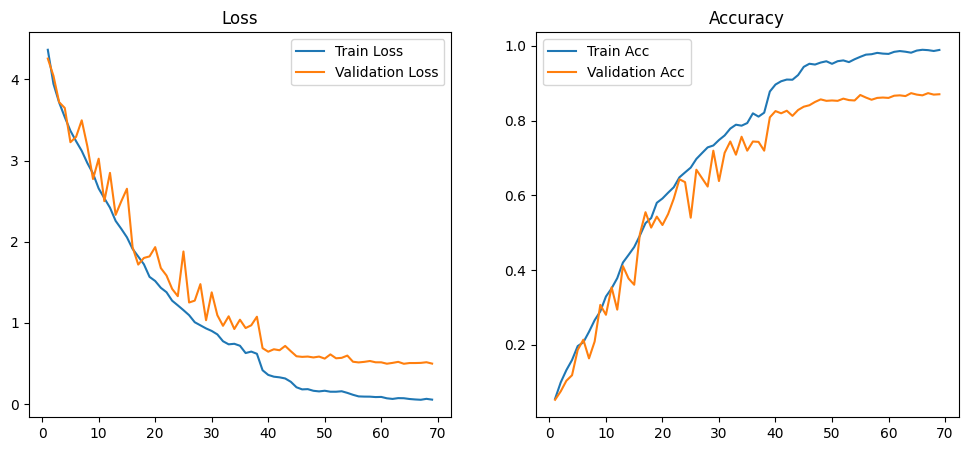

-----------------------------------------------------------------------
Model: Resnet34 , Batch size: 32
-----------------------------------------------------------------------
Epoch [1/200], Train Loss: 4.5667, Train Acc: 0.0436, Val Loss: 5.5663, Val Acc: 0.0255
Epoch [2/200], Train Loss: 4.1835, Train Acc: 0.0628, Val Loss: 4.3205, Val Acc: 0.0382
Epoch [3/200], Train Loss: 4.0367, Train Acc: 0.0805, Val Loss: 4.1176, Val Acc: 0.0520
Epoch [4/200], Train Loss: 3.8969, Train Acc: 0.0951, Val Loss: 4.4422, Val Acc: 0.0422
Epoch [5/200], Train Loss: 3.7974, Train Acc: 0.1064, Val Loss: 3.7319, Val Acc: 0.0814
Epoch [6/200], Train Loss: 3.6981, Train Acc: 0.1337, Val Loss: 3.6267, Val Acc: 0.0931
Epoch [7/200], Train Loss: 3.6240, Train Acc: 0.1374, Val Loss: 3.8744, Val Acc: 0.0843
Epoch [8/200], Train Loss: 3.5053, Train Acc: 0.1537, Val Loss: 3.5263, Val Acc: 0.1176
Epoch [9/200], Train Loss: 3.4769, Train Acc: 0.1617, Val Loss: 3.4854, Val Acc: 0.1490
Epoch [10/200], Train Loss: 3.3

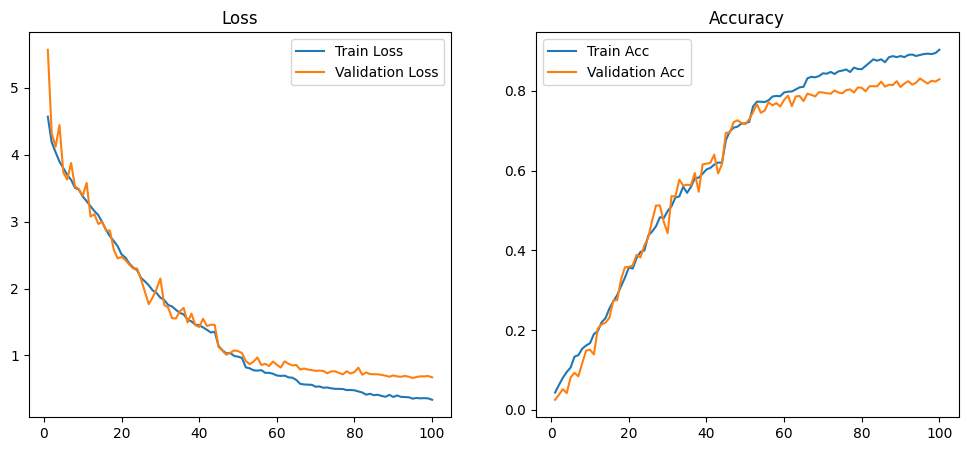

-----------------------------------------------------------------------
Model: Resnet18 , Batch size: 64
-----------------------------------------------------------------------
Epoch [1/200], Train Loss: 4.3211, Train Acc: 0.0691, Val Loss: 4.2646, Val Acc: 0.0598
Epoch [2/200], Train Loss: 3.8641, Train Acc: 0.1124, Val Loss: 3.8109, Val Acc: 0.0941
Epoch [3/200], Train Loss: 3.6674, Train Acc: 0.1325, Val Loss: 3.6967, Val Acc: 0.1127
Epoch [4/200], Train Loss: 3.4691, Train Acc: 0.1538, Val Loss: 3.6649, Val Acc: 0.1245
Epoch [5/200], Train Loss: 3.3292, Train Acc: 0.1867, Val Loss: 3.6016, Val Acc: 0.1549
Epoch [6/200], Train Loss: 3.2017, Train Acc: 0.2134, Val Loss: 3.1971, Val Acc: 0.1814
Epoch [7/200], Train Loss: 3.0609, Train Acc: 0.2392, Val Loss: 3.0405, Val Acc: 0.2225
Epoch [8/200], Train Loss: 2.9140, Train Acc: 0.2758, Val Loss: 3.4786, Val Acc: 0.1980
Epoch [9/200], Train Loss: 2.8299, Train Acc: 0.2961, Val Loss: 2.8948, Val Acc: 0.2735
Epoch [10/200], Train Loss: 2.7

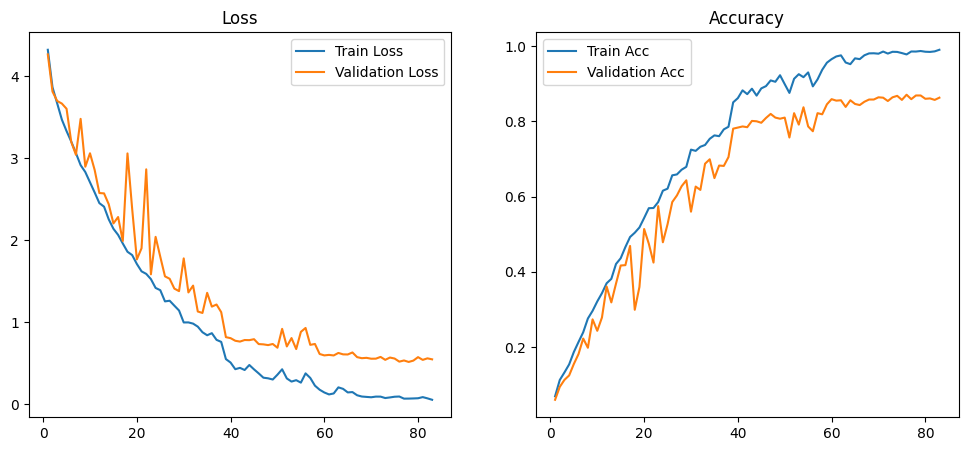

-----------------------------------------------------------------------
Model: Resnet34 , Batch size: 64
-----------------------------------------------------------------------
Epoch [1/200], Train Loss: 4.6668, Train Acc: 0.0416, Val Loss: 4.9907, Val Acc: 0.0137
Epoch [2/200], Train Loss: 4.2399, Train Acc: 0.0615, Val Loss: 4.4238, Val Acc: 0.0373
Epoch [3/200], Train Loss: 4.0716, Train Acc: 0.0771, Val Loss: 4.2351, Val Acc: 0.0529
Epoch [4/200], Train Loss: 3.9395, Train Acc: 0.0930, Val Loss: 4.1727, Val Acc: 0.0608
Epoch [5/200], Train Loss: 3.8520, Train Acc: 0.1078, Val Loss: 4.0623, Val Acc: 0.0500
Epoch [6/200], Train Loss: 3.7230, Train Acc: 0.1268, Val Loss: 3.8313, Val Acc: 0.0745
Epoch [7/200], Train Loss: 3.6656, Train Acc: 0.1296, Val Loss: 3.9483, Val Acc: 0.0765
Epoch [8/200], Train Loss: 3.5674, Train Acc: 0.1469, Val Loss: 3.6199, Val Acc: 0.0990
Epoch [9/200], Train Loss: 3.4704, Train Acc: 0.1571, Val Loss: 3.7147, Val Acc: 0.1039
Epoch [10/200], Train Loss: 3.4

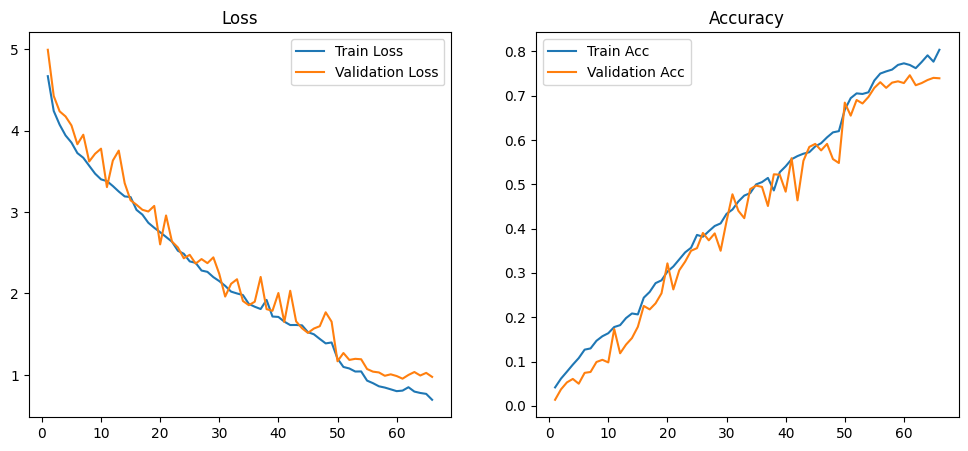

-----------------------------------------------------------------------
Model: Resnet18 , Batch size: 128
-----------------------------------------------------------------------
Epoch [1/200], Train Loss: 4.3311, Train Acc: 0.0751, Val Loss: 4.7910, Val Acc: 0.0412
Epoch [2/200], Train Loss: 3.8676, Train Acc: 0.1072, Val Loss: 3.7886, Val Acc: 0.1069
Epoch [3/200], Train Loss: 3.6718, Train Acc: 0.1381, Val Loss: 3.6913, Val Acc: 0.1206
Epoch [4/200], Train Loss: 3.5074, Train Acc: 0.1514, Val Loss: 3.9974, Val Acc: 0.0863
Epoch [5/200], Train Loss: 3.4357, Train Acc: 0.1706, Val Loss: 3.4990, Val Acc: 0.1471
Epoch [6/200], Train Loss: 3.3353, Train Acc: 0.1857, Val Loss: 3.3378, Val Acc: 0.1863
Epoch [7/200], Train Loss: 3.2281, Train Acc: 0.2166, Val Loss: 4.1877, Val Acc: 0.1216
Epoch [8/200], Train Loss: 3.2412, Train Acc: 0.2083, Val Loss: 3.6899, Val Acc: 0.1490
Epoch [9/200], Train Loss: 3.1112, Train Acc: 0.2313, Val Loss: 3.9022, Val Acc: 0.1461
Epoch [10/200], Train Loss: 3.

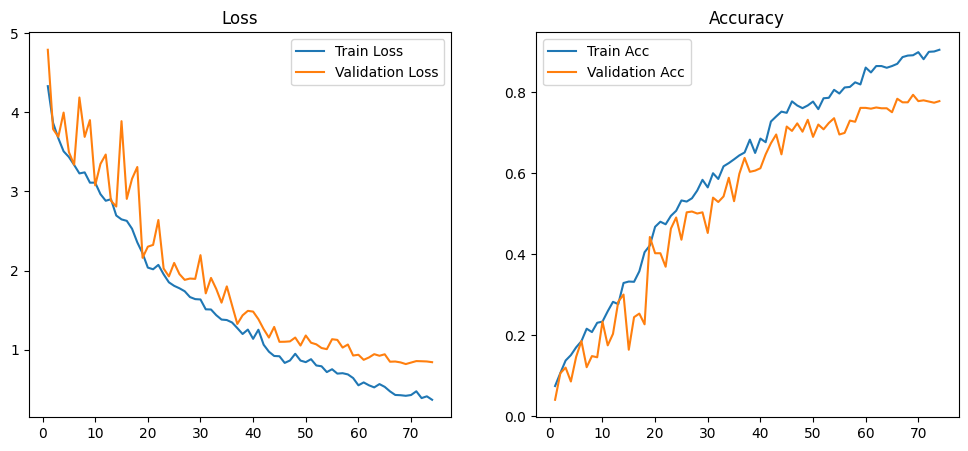

-----------------------------------------------------------------------
Model: Resnet34 , Batch size: 128
-----------------------------------------------------------------------
Epoch [1/200], Train Loss: 4.6490, Train Acc: 0.0418, Val Loss: 5.0850, Val Acc: 0.0314
Epoch [2/200], Train Loss: 4.2169, Train Acc: 0.0577, Val Loss: 4.1861, Val Acc: 0.0363
Epoch [3/200], Train Loss: 4.0634, Train Acc: 0.0766, Val Loss: 4.1165, Val Acc: 0.0578
Epoch [4/200], Train Loss: 3.9334, Train Acc: 0.0951, Val Loss: 4.1832, Val Acc: 0.0422
Epoch [5/200], Train Loss: 3.8566, Train Acc: 0.1023, Val Loss: 4.1263, Val Acc: 0.0500
Epoch [6/200], Train Loss: 3.8655, Train Acc: 0.1055, Val Loss: 4.3080, Val Acc: 0.0510
Epoch [7/200], Train Loss: 3.8417, Train Acc: 0.1026, Val Loss: 3.9748, Val Acc: 0.0657
Epoch [8/200], Train Loss: 3.7562, Train Acc: 0.1164, Val Loss: 3.6942, Val Acc: 0.0794
Epoch [9/200], Train Loss: 3.6450, Train Acc: 0.1285, Val Loss: 3.7369, Val Acc: 0.0843
Epoch [10/200], Train Loss: 3.

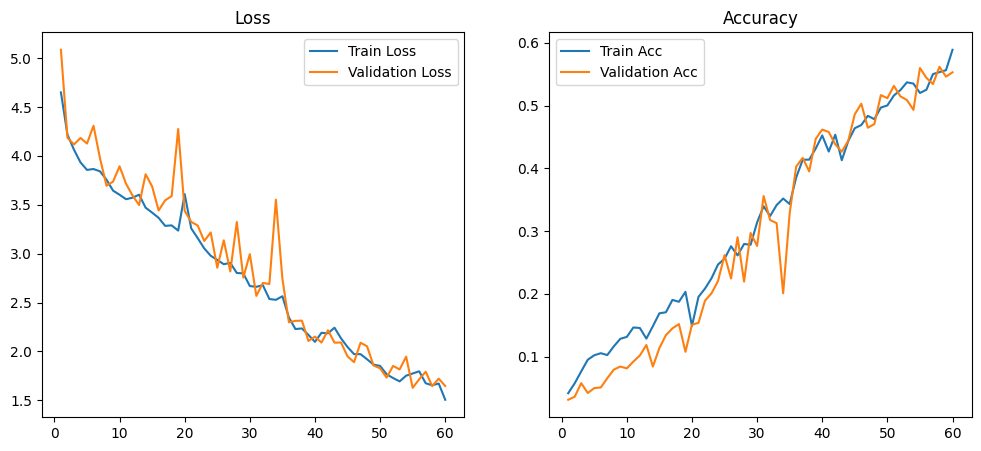

-----------------------------------------------------------------------
Model: Resnet18 , Batch size: 200
-----------------------------------------------------------------------
Epoch [1/200], Train Loss: 4.3434, Train Acc: 0.0732, Val Loss: 6.9159, Val Acc: 0.0304
Epoch [2/200], Train Loss: 3.8372, Train Acc: 0.1161, Val Loss: 4.6717, Val Acc: 0.0647
Epoch [3/200], Train Loss: 3.6135, Train Acc: 0.1504, Val Loss: 3.8254, Val Acc: 0.1020
Epoch [4/200], Train Loss: 3.4380, Train Acc: 0.1735, Val Loss: 3.6645, Val Acc: 0.1392
Epoch [5/200], Train Loss: 3.2997, Train Acc: 0.1968, Val Loss: 3.7291, Val Acc: 0.1225
Epoch [6/200], Train Loss: 3.1739, Train Acc: 0.2208, Val Loss: 3.2408, Val Acc: 0.1922
Epoch [7/200], Train Loss: 2.9912, Train Acc: 0.2552, Val Loss: 3.3840, Val Acc: 0.1941
Epoch [8/200], Train Loss: 2.8861, Train Acc: 0.2757, Val Loss: 3.2480, Val Acc: 0.2373
Epoch [9/200], Train Loss: 2.7075, Train Acc: 0.3132, Val Loss: 3.1103, Val Acc: 0.2333
Epoch [10/200], Train Loss: 2.

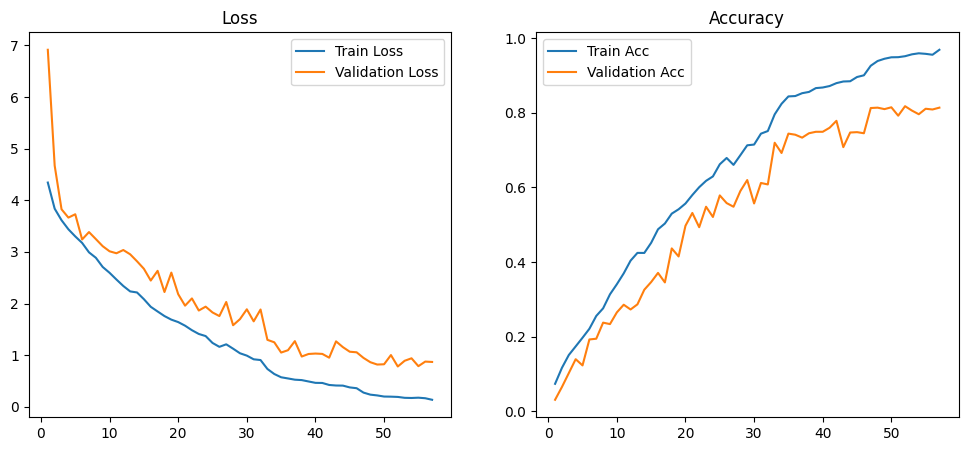

-----------------------------------------------------------------------
Model: Resnet34 , Batch size: 200
-----------------------------------------------------------------------
Epoch [1/200], Train Loss: 4.6754, Train Acc: 0.0345, Val Loss: 10.8530, Val Acc: 0.0176
Epoch [2/200], Train Loss: 4.2426, Train Acc: 0.0652, Val Loss: 4.6704, Val Acc: 0.0392
Epoch [3/200], Train Loss: 4.0042, Train Acc: 0.0893, Val Loss: 4.3028, Val Acc: 0.0608
Epoch [4/200], Train Loss: 3.8159, Train Acc: 0.1163, Val Loss: 4.0015, Val Acc: 0.0745
Epoch [5/200], Train Loss: 3.6857, Train Acc: 0.1327, Val Loss: 3.8974, Val Acc: 0.0980
Epoch [6/200], Train Loss: 3.5405, Train Acc: 0.1470, Val Loss: 4.0206, Val Acc: 0.0657
Epoch [7/200], Train Loss: 3.4788, Train Acc: 0.1574, Val Loss: 3.7217, Val Acc: 0.1314
Epoch [8/200], Train Loss: 3.3981, Train Acc: 0.1768, Val Loss: 3.7335, Val Acc: 0.1284
Epoch [9/200], Train Loss: 3.3004, Train Acc: 0.1926, Val Loss: 3.5977, Val Acc: 0.1588
Epoch [10/200], Train Loss: 3

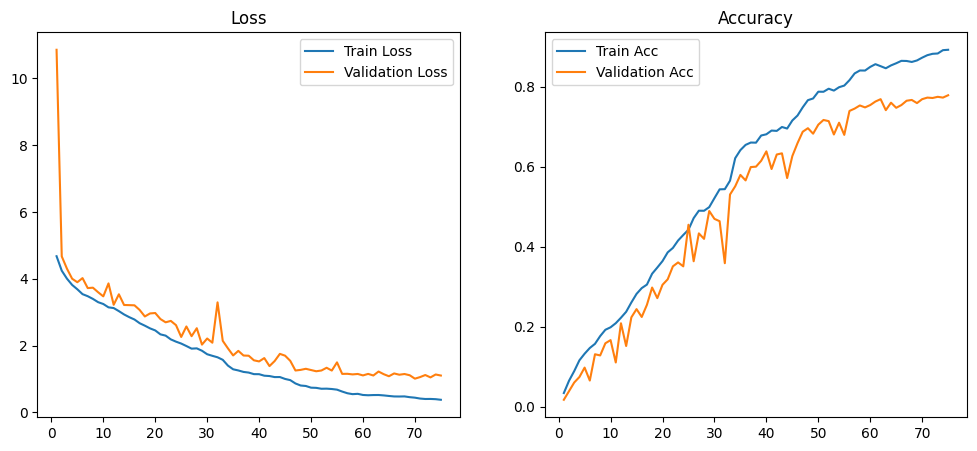

In [14]:
batch_sizes = [32, 64, 128, 200]
learning_rate=0.001
epochs=200
weight_decay=0.0001
factor=0.5
patience=3
results_resnet18 = []
results_resnet34= []


for batch_size in batch_sizes:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=10)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    print('-----------------------------------------------------------------------')
    print(f'Model: Resnet18 , Batch size: {batch_size}')
    print('-----------------------------------------------------------------------')

    # 模型 resnet18
    model_resnet18 = ResNet18(num_classes=NUM_CLASSES, activation_fn=nn.ReLU)
    criterion = nn.CrossEntropyLoss(weight=scaled_weights) 
    optimizer = optim.Adam(model_resnet18.parameters(), lr=learning_rate, weight_decay=weight_decay)  # 引入權重衰減
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=patience)
    train_loss, train_acc, val_loss, val_acc = train_model(model_resnet18, train_loader, val_loader, criterion, optimizer, epochs, scheduler, early_stopping_patience=5)
    results_resnet18.append((train_loss, train_acc, val_loss, val_acc))

    plot_loss_acc(train_loss, val_loss, train_acc, val_acc)

    print('-----------------------------------------------------------------------')
    print(f'Model: Resnet34 , Batch size: {batch_size}')
    print('-----------------------------------------------------------------------')


    # 模型 resnet34
    model_resnet34 = ResNet34(num_classes=NUM_CLASSES, activation_fn=nn.ReLU)
    criterion = nn.CrossEntropyLoss(weight=scaled_weights) 
    optimizer = optim.Adam(model_resnet34.parameters(), lr=learning_rate, weight_decay=weight_decay)  # 引入權重衰減
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=patience)
    train_loss, train_acc, val_loss, val_acc = train_model(model_resnet34, train_loader, val_loader, criterion, optimizer, epochs, scheduler, early_stopping_patience=5)
    results_resnet34.append((train_loss, train_acc, val_loss, val_acc))

    plot_loss_acc(train_loss, val_loss, train_acc, val_acc)

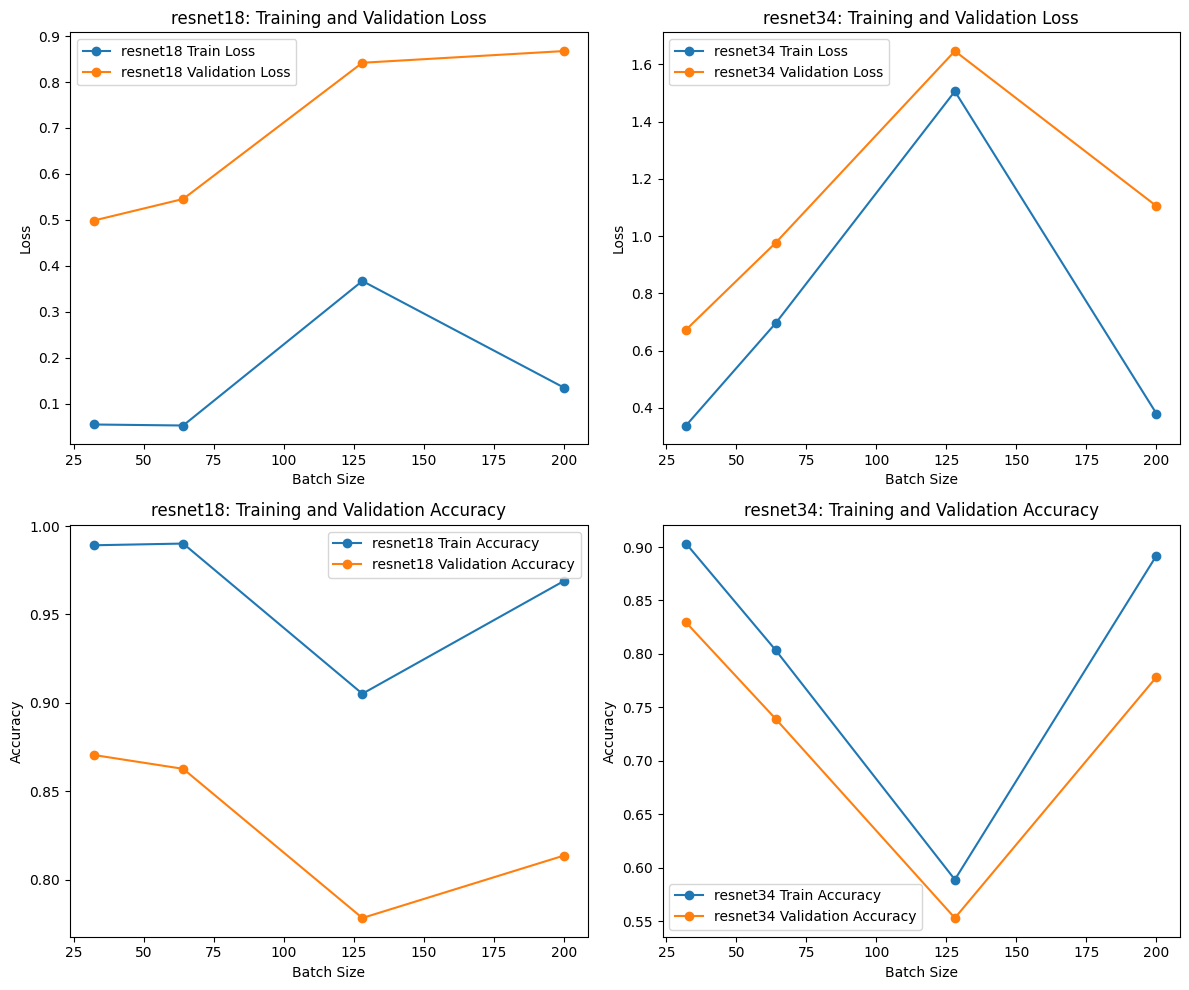

In [15]:
# 提取結果
train_losses_resnet18, train_accs_resnet18, val_losses_resnet18, val_accs_resnet18 = [], [], [], []
train_losses_resnet34, train_accs_resnet34, val_losses_resnet34, val_accs_resnet34 = [], [], [], []

# 提取 resnet18 模型的結果
for result in results_resnet18:
    train_loss, train_acc, val_loss, val_acc = result
    train_losses_resnet18.append(train_loss[-1])  # 獲取最後一個 epoch 的損失
    train_accs_resnet18.append(train_acc[-1])     # 獲取最後一個 epoch 的準確率
    val_losses_resnet18.append(val_loss[-1])
    val_accs_resnet18.append(val_acc[-1])

# 提取 resnet34 模型的結果
for result in results_resnet34:
    train_loss, train_acc, val_loss, val_acc = result
    train_losses_resnet34.append(train_loss[-1])  # 獲取最後一個 epoch 的損失
    train_accs_resnet34.append(train_acc[-1])     # 獲取最後一個 epoch 的準確率
    val_losses_resnet34.append(val_loss[-1])
    val_accs_resnet34.append(val_acc[-1])

# 轉換為 NumPy 陣列以便進一步分析
train_losses_resnet18 = np.array(train_losses_resnet18)
train_accs_resnet18 = np.array(train_accs_resnet18)
val_losses_resnet18 = np.array(val_losses_resnet18)
val_accs_resnet18 = np.array(val_accs_resnet18)

train_losses_resnet34 = np.array(train_losses_resnet34)
train_accs_resnet34 = np.array(train_accs_resnet34)
val_losses_resnet34 = np.array(val_losses_resnet34)
val_accs_resnet34 = np.array(val_accs_resnet34)

plt.figure(figsize=(12, 10))

# 損失比較
plt.subplot(2, 2, 1)
plt.plot(batch_sizes, train_losses_resnet18, label='resnet18 Train Loss', marker='o')
plt.plot(batch_sizes, val_losses_resnet18, label='resnet18 Validation Loss', marker='o')
plt.title('resnet18: Training and Validation Loss')
plt.xlabel('Batch Size')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(batch_sizes, train_losses_resnet34, label='resnet34 Train Loss', marker='o')
plt.plot(batch_sizes, val_losses_resnet34, label='resnet34 Validation Loss', marker='o')
plt.title('resnet34: Training and Validation Loss')
plt.xlabel('Batch Size')
plt.ylabel('Loss')
plt.legend()

# 準確率比較
plt.subplot(2, 2, 3)
plt.plot(batch_sizes, train_accs_resnet18, label='resnet18 Train Accuracy', marker='o')
plt.plot(batch_sizes, val_accs_resnet18, label='resnet18 Validation Accuracy', marker='o')
plt.title('resnet18: Training and Validation Accuracy')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(batch_sizes, train_accs_resnet34, label='resnet34 Train Accuracy', marker='o')
plt.plot(batch_sizes, val_accs_resnet34, label='resnet34 Validation Accuracy', marker='o')
plt.title('resnet34: Training and Validation Accuracy')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [39]:
batch_sizes = 32
learning_rate=0.001
epochs=150
weight_decay=0.0001
factor=0.5
patience=3

train_loader = DataLoader(train_dataset, batch_size=batch_sizes, shuffle=True, num_workers=10)
val_loader = DataLoader(val_dataset, batch_size=batch_sizes, shuffle=False)

### 增加 ResNet34 的訓練 epochs 並減少 Dropout

Epoch [1/150], Train Loss: 4.4834, Train Acc: 0.0574, Val Loss: 4.4319, Val Acc: 0.0520
Epoch [2/150], Train Loss: 4.0358, Train Acc: 0.0864, Val Loss: 6.4068, Val Acc: 0.0500
Epoch [3/150], Train Loss: 3.8919, Train Acc: 0.0997, Val Loss: 3.8586, Val Acc: 0.0706
Epoch [4/150], Train Loss: 3.7249, Train Acc: 0.1316, Val Loss: 3.7194, Val Acc: 0.1069
Epoch [5/150], Train Loss: 3.6384, Train Acc: 0.1369, Val Loss: 3.5310, Val Acc: 0.1255
Epoch [6/150], Train Loss: 3.5157, Train Acc: 0.1521, Val Loss: 3.6072, Val Acc: 0.1265


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000012932F29D00>
Traceback (most recent call last):
  File "c:\Users\wei\Desktop\programs\deep learning\lab2\Lib\site-packages\torch\utils\data\dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "c:\Users\wei\Desktop\programs\deep learning\lab2\Lib\site-packages\torch\utils\data\dataloader.py", line 1435, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Epoch [7/150], Train Loss: 3.4443, Train Acc: 0.1701, Val Loss: 3.6481, Val Acc: 0.1196
Epoch [8/150], Train Loss: 3.3587, Train Acc: 0.1797, Val Loss: 3.4476, Val Acc: 0.1598
Epoch [9/150], Train Loss: 3.2438, Train Acc: 0.2074, Val Loss: 3.1783, Val Acc: 0.2020
Epoch [10/150], Train Loss: 3.1410, Train Acc: 0.2221, Val Loss: 3.4124, Val Acc: 0.1676
Epoch [11/150], Train Loss: 2.9884, Train Acc: 0.2591, Val Loss: 3.1677, Val Acc: 0.2000
Epoch [12/150], Train Loss: 2.9210, Train Acc: 0.2665, Val Loss: 3.0279, Val Acc: 0.2422
Epoch [13/150], Train Loss: 2.7917, Train Acc: 0.2934, Val Loss: 2.6550, Val Acc: 0.3235
Epoch [14/150], Train Loss: 2.7054, Train Acc: 0.3093, Val Loss: 2.9520, Val Acc: 0.2559
Epoch [15/150], Train Loss: 2.5905, Train Acc: 0.3422, Val Loss: 3.0028, Val Acc: 0.2627
Epoch [16/150], Train Loss: 2.4367, Train Acc: 0.3679, Val Loss: 2.3428, Val Acc: 0.3833
Epoch [17/150], Train Loss: 2.3210, Train Acc: 0.3975, Val Loss: 2.3897, Val Acc: 0.3814
Epoch [18/150], Train Lo

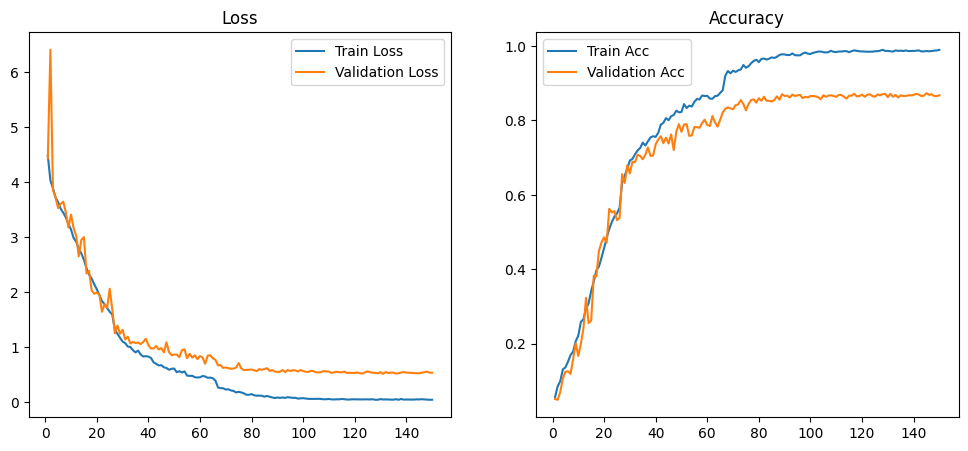

In [40]:
model_resnet34 = ResNet34(num_classes=NUM_CLASSES, activation_fn=nn.ReLU)
criterion = nn.CrossEntropyLoss(weight=scaled_weights) 
optimizer = optim.Adam(model_resnet34.parameters(), lr=learning_rate, weight_decay=weight_decay)  # 引入權重衰減
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=patience)
train_loss, train_acc, val_loss, val_acc = train_model(model_resnet34, train_loader, val_loader, criterion, optimizer, epochs, scheduler)

plot_loss_acc(train_loss, val_loss, train_acc, val_acc)

### 增加 ResNet18 的 Dropout

Epoch [1/150], Train Loss: 4.4321, Train Acc: 0.0618, Val Loss: 4.2663, Val Acc: 0.0608
Epoch [2/150], Train Loss: 3.9250, Train Acc: 0.0992, Val Loss: 3.9845, Val Acc: 0.0912
Epoch [3/150], Train Loss: 3.7600, Train Acc: 0.1216, Val Loss: 3.6102, Val Acc: 0.1206
Epoch [4/150], Train Loss: 3.5674, Train Acc: 0.1498, Val Loss: 3.5719, Val Acc: 0.1235
Epoch [5/150], Train Loss: 3.4378, Train Acc: 0.1607, Val Loss: 3.5873, Val Acc: 0.1412
Epoch [6/150], Train Loss: 3.3074, Train Acc: 0.1937, Val Loss: 3.3435, Val Acc: 0.1608
Epoch [7/150], Train Loss: 3.2202, Train Acc: 0.2129, Val Loss: 3.2182, Val Acc: 0.2176
Epoch [8/150], Train Loss: 3.0840, Train Acc: 0.2389, Val Loss: 2.9735, Val Acc: 0.2265
Epoch [9/150], Train Loss: 2.9290, Train Acc: 0.2594, Val Loss: 3.0016, Val Acc: 0.2294
Epoch [10/150], Train Loss: 2.8456, Train Acc: 0.2815, Val Loss: 2.9262, Val Acc: 0.2402
Epoch [11/150], Train Loss: 2.6622, Train Acc: 0.3270, Val Loss: 2.8671, Val Acc: 0.2598
Epoch [12/150], Train Loss: 2.

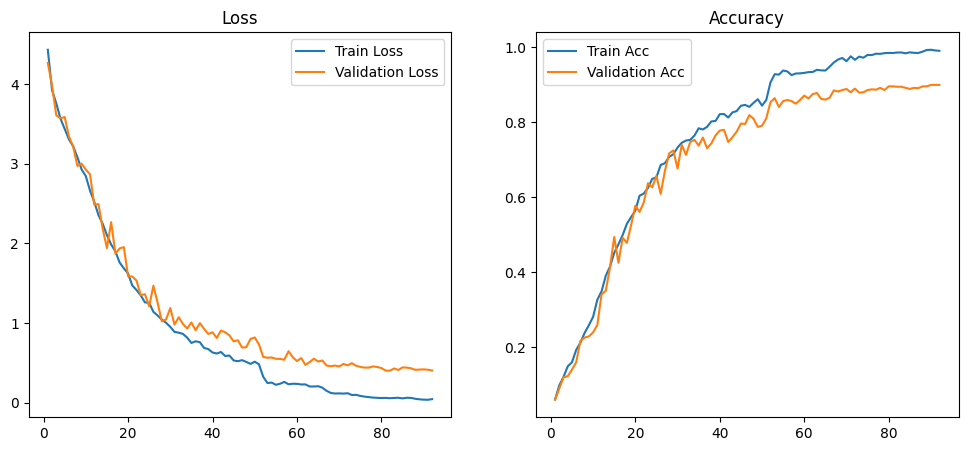

In [41]:
early_stopping_patience=10

model_resnet18 = ResNet18(num_classes=NUM_CLASSES, activation_fn=nn.ReLU)
criterion = nn.CrossEntropyLoss(weight=scaled_weights) 
optimizer = optim.Adam(model_resnet18.parameters(), lr=learning_rate, weight_decay=weight_decay)  # 引入權重衰減
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=patience)
train_loss, train_acc, val_loss, val_acc = train_model(model_resnet18, train_loader, val_loader, criterion, optimizer, epochs, scheduler, early_stopping_patience)

plot_loss_acc(train_loss, val_loss, train_acc, val_acc)

### 比較不同的激發函數

In [13]:
BATCH_SIZE = 32

EPOCHS=150
LEARNING_RATE=0.001
WEIGHT_DECAY=0.0001

# schedular
FACTOR=0.5
PATIENCE=3


early_stopping_patience=10

In [14]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=10)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### ReLu

-----------------------------------------------------------------------
Using Activation Function <class 'torch.nn.modules.activation.ReLU'>
-----------------------------------------------------------------------
Epoch [1/150], Train Loss: 4.3996, Train Acc: 0.0646, Val Loss: 4.1280, Val Acc: 0.0549
Epoch [2/150], Train Loss: 3.9204, Train Acc: 0.1010, Val Loss: 3.9423, Val Acc: 0.1010
Epoch [3/150], Train Loss: 3.7197, Train Acc: 0.1186, Val Loss: 3.6704, Val Acc: 0.1078
Epoch [4/150], Train Loss: 3.5669, Train Acc: 0.1405, Val Loss: 3.5160, Val Acc: 0.1392
Epoch [5/150], Train Loss: 3.4665, Train Acc: 0.1696, Val Loss: 3.4839, Val Acc: 0.1343
Epoch [6/150], Train Loss: 3.3528, Train Acc: 0.1786, Val Loss: 3.1691, Val Acc: 0.2137
Epoch [7/150], Train Loss: 3.2364, Train Acc: 0.2064, Val Loss: 3.2205, Val Acc: 0.2225
Epoch [8/150], Train Loss: 3.1426, Train Acc: 0.2329, Val Loss: 3.0813, Val Acc: 0.2186
Epoch [9/150], Train Loss: 3.0164, Train Acc: 0.2529, Val Loss: 2.8346, Val Acc: 0.

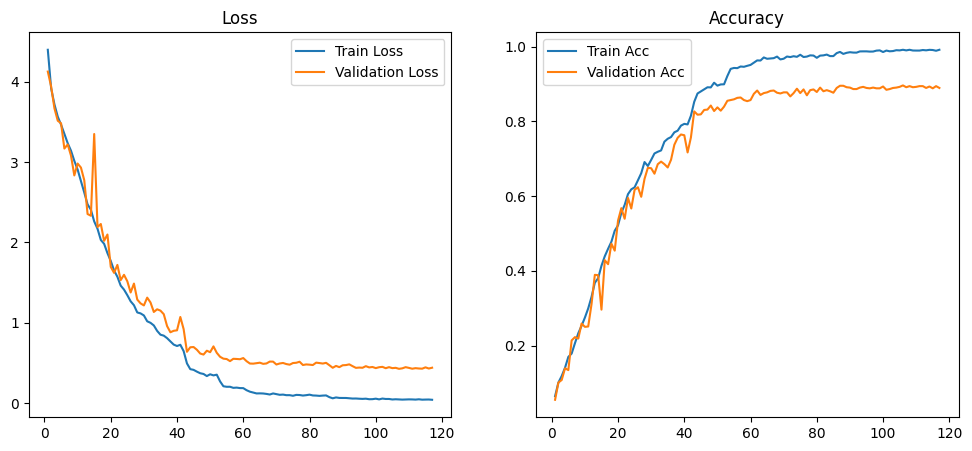

In [25]:
print('-----------------------------------------------------------------------')
print(f'Using Activation Function {nn.ReLU}')
print('-----------------------------------------------------------------------')

model_relu = ResNet18(num_classes=NUM_CLASSES, activation_fn=nn.LeakyReLU)
criterion = nn.CrossEntropyLoss(weight=scaled_weights) 
optimizer = optim.Adam(model_relu.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=FACTOR, patience=PATIENCE)

train_loss, train_acc, val_loss, val_acc = train_model(model_relu, train_loader, val_loader, criterion, optimizer, EPOCHS, scheduler, early_stopping_patience=10)
plot_loss_acc(train_loss, val_loss, train_acc, val_acc)

In [26]:
test_model(model_relu, test_loader)

Test Accuracy: 0.9286


tensor(0.9286, device='cuda:0')

### LeakyReLU

-----------------------------------------------------------------------
Using Activation Function <class 'torch.nn.modules.activation.LeakyReLU'>
-----------------------------------------------------------------------
Epoch [1/150], Train Loss: 4.3665, Train Acc: 0.0615, Val Loss: 4.3250, Val Acc: 0.0500
Epoch [2/150], Train Loss: 3.9044, Train Acc: 0.1031, Val Loss: 3.9203, Val Acc: 0.0902
Epoch [3/150], Train Loss: 3.7426, Train Acc: 0.1236, Val Loss: 3.6467, Val Acc: 0.1235
Epoch [4/150], Train Loss: 3.5935, Train Acc: 0.1415, Val Loss: 3.5680, Val Acc: 0.1373
Epoch [5/150], Train Loss: 3.4786, Train Acc: 0.1563, Val Loss: 3.5542, Val Acc: 0.1284
Epoch [6/150], Train Loss: 3.3381, Train Acc: 0.1859, Val Loss: 3.4978, Val Acc: 0.1588
Epoch [7/150], Train Loss: 3.2535, Train Acc: 0.2070, Val Loss: 3.3695, Val Acc: 0.1608
Epoch [8/150], Train Loss: 3.1908, Train Acc: 0.2139, Val Loss: 3.3830, Val Acc: 0.1706
Epoch [9/150], Train Loss: 3.0108, Train Acc: 0.2534, Val Loss: 2.9550, Val Ac

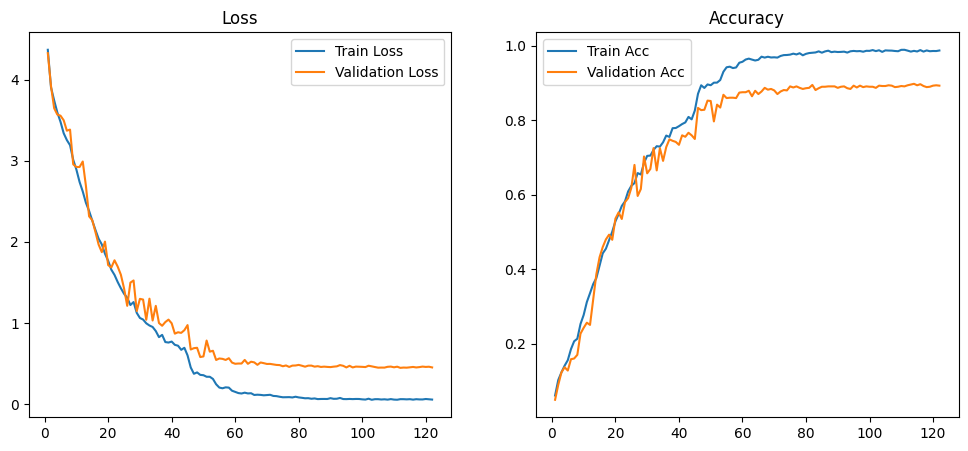

In [28]:
print('-----------------------------------------------------------------------')
print(f'Using Activation Function {nn.LeakyReLU}')
print('-----------------------------------------------------------------------')

model_leaky_reLU = ResNet18(num_classes=NUM_CLASSES, activation_fn=nn.LeakyReLU)
criterion = nn.CrossEntropyLoss(weight=scaled_weights) 
optimizer = optim.Adam(model_leaky_reLU.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=FACTOR, patience=PATIENCE)

train_loss, train_acc, val_loss, val_acc = train_model(model_leaky_reLU, train_loader, val_loader, criterion, optimizer, EPOCHS, scheduler, early_stopping_patience=10)
plot_loss_acc(train_loss, val_loss, train_acc, val_acc)

In [29]:
test_model(model_leaky_reLU, test_loader)

Test Accuracy: 0.8929


tensor(0.8929, device='cuda:0')

### SiLU

-----------------------------------------------------------------------
Using Activation Function <class 'torch.nn.modules.activation.SiLU'>
-----------------------------------------------------------------------
Epoch [1/150], Train Loss: 4.3408, Train Acc: 0.0716, Val Loss: 4.3894, Val Acc: 0.0510
Epoch [2/150], Train Loss: 3.9315, Train Acc: 0.0917, Val Loss: 3.9144, Val Acc: 0.0725
Epoch [3/150], Train Loss: 3.7255, Train Acc: 0.1189, Val Loss: 3.6397, Val Acc: 0.1167
Epoch [4/150], Train Loss: 3.5700, Train Acc: 0.1555, Val Loss: 3.7839, Val Acc: 0.1275
Epoch [5/150], Train Loss: 3.4162, Train Acc: 0.1812, Val Loss: 3.5752, Val Acc: 0.1333
Epoch [6/150], Train Loss: 3.2858, Train Acc: 0.2043, Val Loss: 3.2661, Val Acc: 0.1961
Epoch [7/150], Train Loss: 3.1396, Train Acc: 0.2301, Val Loss: 3.1368, Val Acc: 0.2284
Epoch [8/150], Train Loss: 2.9724, Train Acc: 0.2675, Val Loss: 2.9581, Val Acc: 0.2343
Epoch [9/150], Train Loss: 2.8165, Train Acc: 0.2906, Val Loss: 3.0123, Val Acc: 0.

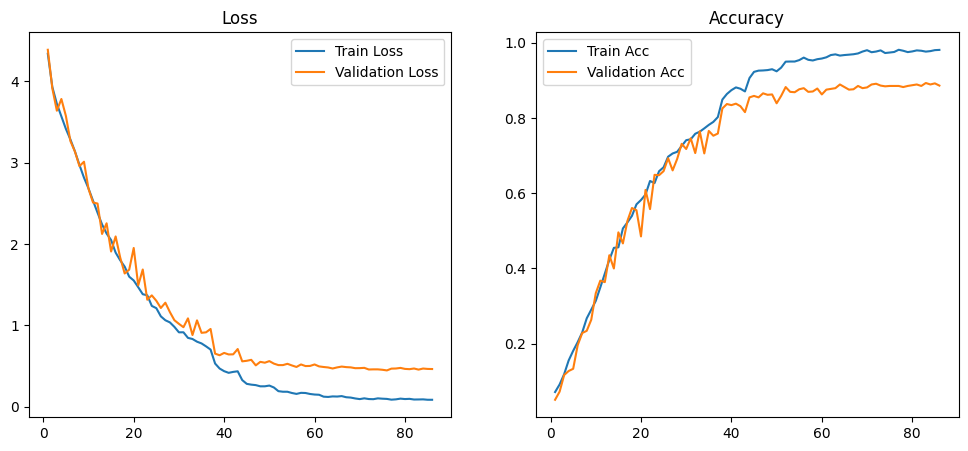

In [23]:
print('-----------------------------------------------------------------------')
print(f'Using Activation Function {nn.SiLU}')
print('-----------------------------------------------------------------------')

model_silu = ResNet18(num_classes=NUM_CLASSES, activation_fn=nn.SiLU)
criterion = nn.CrossEntropyLoss(weight=scaled_weights) 
optimizer = optim.Adam(model_silu.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=FACTOR, patience=PATIENCE)

train_loss, train_acc, val_loss, val_acc = train_model(model_silu, train_loader, val_loader, criterion, optimizer, EPOCHS, scheduler, early_stopping_patience=10)
plot_loss_acc(train_loss, val_loss, train_acc, val_acc)

In [24]:
test_model(model_silu, test_loader)

Test Accuracy: 0.8571


tensor(0.8571, device='cuda:0')

### 比較 Lab0

In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((32, 32)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# you can try other transforms, e.g. add random flip, random crop or etc to augment your data.
trainset = datasets.Flowers102(root='./data', split='test', download=True, transform=transform)  
# transet is an iterable object, you can use for loop to access the data or get any data use 'trainset[<int>]'.
trainloader = DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

valdataset = datasets.Flowers102(root='./data', split='val', download=True, transform=transform)
valloader = DataLoader(valdataset, batch_size=64, shuffle=False)

# trainloader is an dataloader object from pytorch, you can use for loop to access the data,
# or use next(iter(trainloader)) to get a batch of data.
testset = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)

testloader = DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)


In [11]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 102)
        # you can try other module like dropout, batch normalization, etc to improve model.
        # And other activation function like sigmoid, tanh, etc.
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# you can try other optimizer like Adam, RMSprop, etc.

In [13]:
EPOCHS = 150 # you can try more epochs number to get better performance.

train_loss, train_acc, val_loss, val_acc = train_model(net, trainloader, valloader, criterion, optimizer, EPOCHS)

Epoch [1/150], Train Loss: 4.6173, Train Acc: 0.0057, Val Loss: 4.6270, Val Acc: 0.0098
Epoch [2/150], Train Loss: 4.6099, Train Acc: 0.0117, Val Loss: 4.6270, Val Acc: 0.0118
Epoch [3/150], Train Loss: 4.6025, Train Acc: 0.0355, Val Loss: 4.6271, Val Acc: 0.0098
Epoch [4/150], Train Loss: 4.5955, Train Acc: 0.0385, Val Loss: 4.6274, Val Acc: 0.0098
Epoch [5/150], Train Loss: 4.5882, Train Acc: 0.0387, Val Loss: 4.6277, Val Acc: 0.0098
Epoch [6/150], Train Loss: 4.5787, Train Acc: 0.0387, Val Loss: 4.6284, Val Acc: 0.0098
Epoch [7/150], Train Loss: 4.5664, Train Acc: 0.0387, Val Loss: 4.6294, Val Acc: 0.0098
Epoch [8/150], Train Loss: 4.5425, Train Acc: 0.0364, Val Loss: 4.6342, Val Acc: 0.0137
Epoch [9/150], Train Loss: 4.4833, Train Acc: 0.0342, Val Loss: 4.6854, Val Acc: 0.0127
Epoch [10/150], Train Loss: 4.4105, Train Acc: 0.0496, Val Loss: 4.7234, Val Acc: 0.0176
Epoch [11/150], Train Loss: 4.3736, Train Acc: 0.0530, Val Loss: 4.7391, Val Acc: 0.0176
Epoch [12/150], Train Loss: 4.

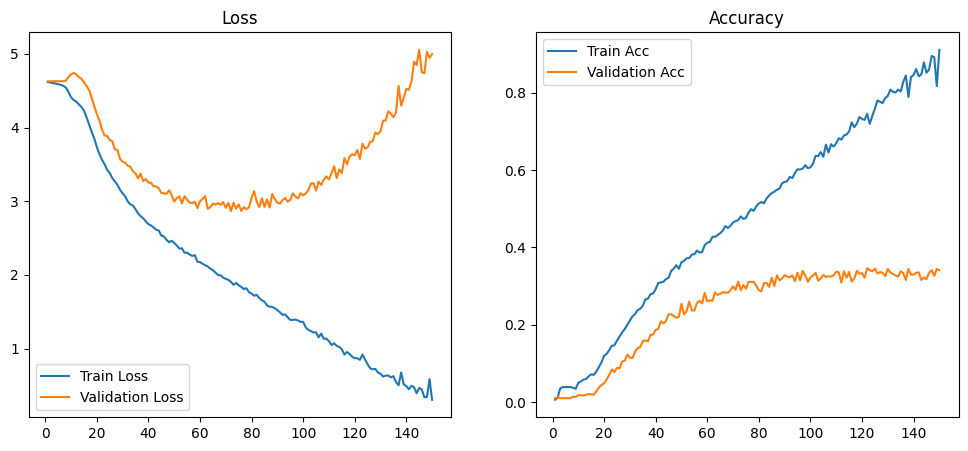

In [14]:
plot_loss_acc(train_loss, val_loss, train_acc, val_acc)

In [15]:
test_model(net, testloader)

Test Accuracy: 0.2333


tensor(0.2333, device='cuda:0')